In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed, Masking
from tensorflow.keras.optimizers import Adam
import h5py
import matplotlib.pyplot as plt
import numpy.ma as ma

In [2]:
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (20,12)
figure(figsize=(100, 80), dpi=80)

<Figure size 8000x6400 with 0 Axes>

<Figure size 8000x6400 with 0 Axes>

In [3]:
tf.random.set_seed(12345)

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [7]:
f = h5py.File("C:/Users/Utilizador/Desktop/WorkinServer/AutoBus/autobuses_processed_data.h5","r")
scaled_X = ma.array(f["scaled_x"])
scaled_X.mask = ma.array(f["x_mask"])
minX = np.array(f["minX"])
maxX = np.array(f["maxX"])
f.close()

In [16]:
def Dataset(train, timesteps):
    X_train = ma.array([train[t:t+timesteps] for t in range(0,len(train)-timesteps)])
    y_train = train[timesteps:, :]
    return X_train, y_train

train_X_data = []
train_Y_data = []

[train_X_data, train_Y_data]=Dataset(scaled_X, 24)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()

In [23]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience=12, min_delta=0.00001, mode='min')

In [24]:
def LSTM_function(NCells, timesteps, num_features, dropout, NBEpochs, Batchsize, validationSplit, earlystopping):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(timesteps, num_features)))
    model.add(LSTM(1, activation = 'tanh', input_shape = (timesteps, num_features), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(NCells))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss = 'mse', optimizer='adam')
    X_ = ma.filled(train_X_data,0)
    Y_ = ma.filled(train_Y_data,0)
    MODEL = model.fit(X_, Y_, epochs = NBEpochs, batch_size = Batchsize,
                      validation_split = validationSplit, shuffle = False,
                      callbacks=[earlystopping])
    return model, MODEL

In [27]:
df_train = []
df_validation = []

[model, MODEL] = LSTM_function(64,np.shape(train_X_data)[1], 1, 0.1, 200, 128, 0.2, early_stopping)
df_train.append(MODEL.history['loss'])
df_validation.append(MODEL.history['val_loss'])

Epoch 1/200
130/130 [==============================] - 12s 45ms/step - loss: 0.0238 - val_loss: 0.0154
Epoch 2/200
130/130 [==============================] - 4s 28ms/step - loss: 0.0126 - val_loss: 0.0118
Epoch 3/200
130/130 [==============================] - 4s 28ms/step - loss: 0.0102 - val_loss: 0.0087
Epoch 4/200
130/130 [==============================] - 4s 28ms/step - loss: 0.0076 - val_loss: 0.0055
Epoch 5/200
130/130 [==============================] - 4s 28ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 6/200
130/130 [==============================] - 4s 28ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 7/200
130/130 [==============================] - 4s 28ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 8/200
130/130 [==============================] - 4s 28ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 9/200
130/130 [==============================] - 4s 29ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 10/200
130/130 [==============================] - 4s 28ms/step - loss: 0.00

130/130 [==============================] - 4s 28ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 81/200
130/130 [==============================] - 4s 27ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 82/200
130/130 [==============================] - 4s 28ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 83/200
130/130 [==============================] - 4s 28ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 84/200
130/130 [==============================] - 4s 28ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 85/200
130/130 [==============================] - 4s 28ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 86/200
130/130 [==============================] - 4s 28ms/step - loss: 0.0016 - val_loss: 0.0011


In [30]:
model.save('/home/costa/JoaoModelsForAlicante/AutoBus/models/AutobusModel.h5')

In [123]:
train_X_data.shape

(20760, 24, 1)

In [124]:
scaled_X.shape

(20784, 1)

In [149]:
inputs = scaled_X[len(scaled_X) - len(test_df) - timesteps:]

In [150]:
inputs = inputs.reshape(-1,1)

In [151]:
inputs.shape

(5220, 1)

In [188]:
X_test = []

In [189]:
for i in range(24, 96):
    X_test.append(inputs[i-timesteps:i,0])

In [190]:
X_test = np.array(X_test)

In [191]:
X_test.shape

(72, 24)

In [192]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [193]:
X_test.shape

(72, 24, 1)

In [194]:
predicted_demand = model.predict(X_test)

In [195]:
def inverse_scaler(scaled_x,minX,maxX):
    return scaled_x*maxX-minX

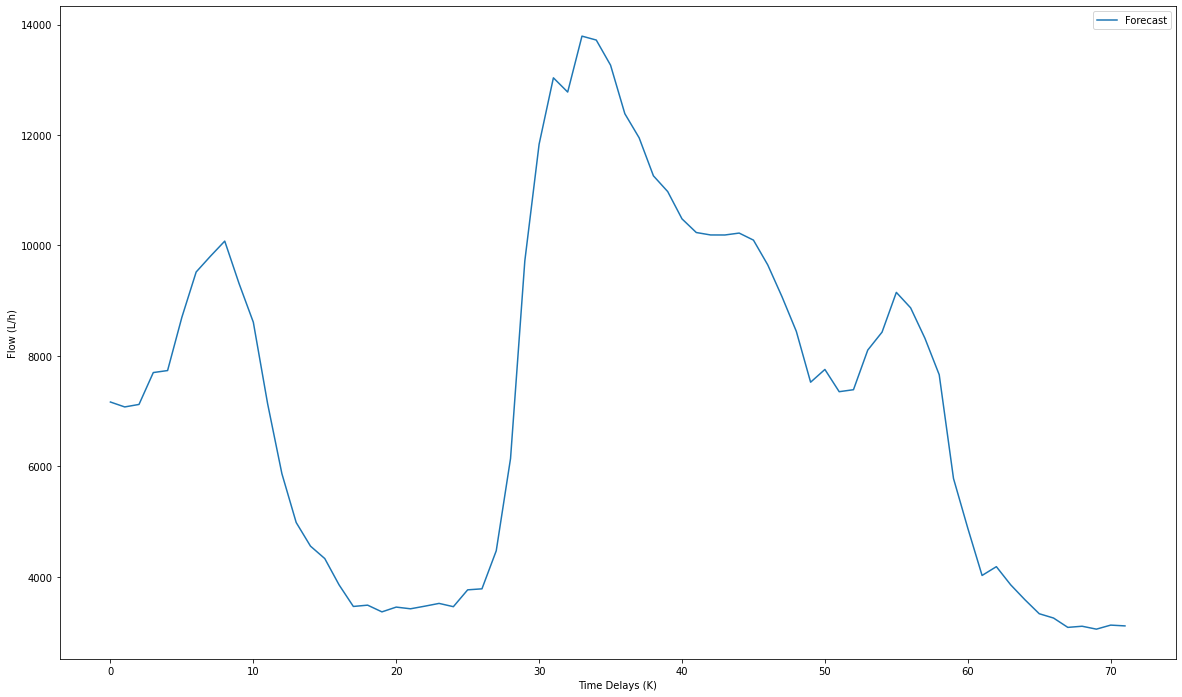

In [196]:
plt.plot(inverse_scaler(predicted_demand, minX, maxX), label = 'Forecast')
plt.legend(loc = 'best')
plt.xlabel('Time Delays (K)')
plt.ylabel('Flow (L/h)')
plt.savefig('prediction.jpg')